Idea behind SVD localization is to use the leading directions of the sample correlation of a coarse but large ensemble of $X$ as the leading directions of the small but fine ensemble of $Z$.
$$
C_X = \mbox{corr}(X)
$$

$$
U S V^{T} = C_X
$$

This is on a coarse scale and must be interpolated to the finer $Z$ scale resulting in $\tilde{V}$.

$$
C_Z = \mbox{corr}(Z)
$$

$$
C_{Z}^{\parallel} = \tilde{V} \mbox{diag}( \mbox{diag}( \tilde{V}^T C_Z \tilde{V} ) ) \tilde{V}^T
$$

$$
C_{Z}^{\bot} = C_Z - C_Z^{\parallel}
$$

$$
C_{Z}^{loc} = C_Z^{\parallel} + C_{\rho} \circ C_Z^{\bot}
$$

$$
P_Z^{loc} = D^{1/2} C_Z^{loc} D^{1/2}
$$

Where $C_{\rho}$ is a localization matrix for the fine scale correlation function, and $D$ is a diagonal matrix with the sample vairance of $Z$ on the diagonal.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage

In [2]:
from multi_loc import covariance, assimilate, utilities

In [3]:
%matplotlib inline
def imshow(X, title=None, vmin=None, vmax=None, cmap=None, dpi=None):
    plt.figure(dpi=dpi)
    im = plt.imshow(X, vmin=vmin, vmax=vmax, cmap=cmap)
    plt.colorbar(im)
    plt.title(title)

In [4]:
Nz = 2**9
rho0_l = 0.2
rho0_s = 0.002
# rho0_s = 0.004

dz = 1/Nz
z = np.arange(Nz)

rhoH0 = 0.003
# [Hz] = covariance.generate_circulant(Nz, dz, rhoH0,
#                                    covariance.fft_sqd_exp_1d,
#                                    return_Corr=True,
#                                    return_eig=False)
# Hz = Hz / Hz.sum(axis=0)[:, None]
Hz = np.eye(Nz)[::2]

Ny = Hz.shape[0]
y = Hz @ z

coarse = 8
Nx = Nz // coarse
dx = dz * coarse
Sz2x = np.eye(Nz)[::coarse]
Sx2z = utilities.lin_interp_matrix(Nz, coarse)

Hx = Hz @ Sx2z
x = Sz2x @ z

l_max = 0.9
l_min = 0.2
var = 8 * Nz
zz = np.arange(Nz) - (Nz - 1)/2
D_l = 1 - np.exp(-(zz)**2/(2 * var))
D_l = (D_l - D_l.min())/(D_l.max() - D_l.min())
D_l = D_l * (l_max - l_min) + l_min
D_s = 1 - D_l
D_l = np.diag(np.sqrt(D_l))
D_s = np.diag(np.sqrt(D_s))

eig_val_l, eig_vec_l, P_l, sort_index = covariance.generate_circulant(
    Nz, dz, rho0_l, covariance.fft_sqd_exp_1d,
    return_Corr=True, return_sort_ind=True)
print('long variance: ', eig_val_l.mean())
eig_val_l = eig_val_l / eig_val_l.mean()
sort_index = np.argsort(sort_index)
eig_val_l = eig_val_l[sort_index]
eig_vec_l = eig_vec_l[:, sort_index]
P_l = eig_vec_l @ np.diag(eig_val_l) @ eig_vec_l.conj().T
P_l = P_l.real

eig_val_s, eig_vec_s, P_s, sort_index = covariance.generate_circulant(
    Nz, dz, rho0_s, covariance.fft_sqd_exp_1d,
    return_Corr=True, return_sort_ind=True)
print('short variance: ', eig_val_s.mean())
eig_val_s = eig_val_s / eig_val_s.mean()
sort_index = np.argsort(sort_index)
eig_val_s = eig_val_s[sort_index]
eig_vec_s = eig_vec_s[:, sort_index]
P_s = eig_vec_s @ np.diag(eig_val_s) @ eig_vec_s.conj().T
P_s = P_s.real

P_l_hetero = (D_l @ P_l @ D_l)
P_s_hetero = (D_s @ P_s @ D_s)
Pz = P_l_hetero + P_s_hetero

# a_l = 0.5
# Pz = a_l * P_l + (1 - a_l) * P_s

Lam_z, Qz = np.linalg.eigh(Pz)
Lam_z = Lam_z[::-1]
Qz = Qz[:, ::-1]

R_var = 0.1
R = R_var * np.eye(Ny)
trans_mats_true = assimilate.transformation_matrices(
    Hz, P=Pz,
    R=R, return_Ts=True)
for key, val in trans_mats_true.items():
    exec(key + 'z=val')
    
Px = Pz[::coarse, ::coarse]
Lam_x, Qx = np.linalg.eigh(Px)
Lam_x = Lam_x[::-1]
Qx = Qx[:, ::-1]
trans_mats_x = assimilate.transformation_matrices(
    Hx, P=Px,
    R=R, return_Ts=True)
for key, val in trans_mats_x.items():
    exec(key + 'x=val')

long variance:  1.000007453306344
short variance:  0.9987043816800435


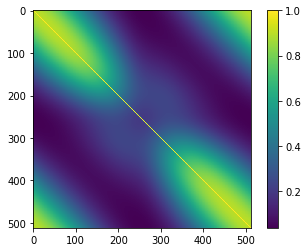

In [5]:
imshow(Pz)

In [6]:
dQxdt = np.diff(Qx, axis=0)
d2Qxdt2 = np.diff(dQxdt, axis=0)

/Users/harty/miniconda3/envs/loc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


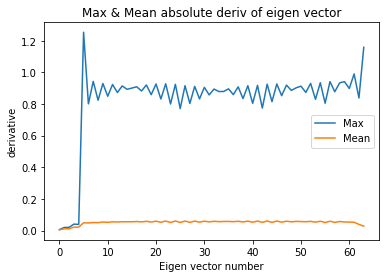

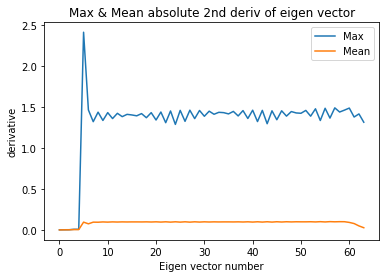

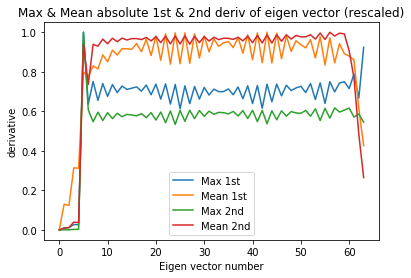

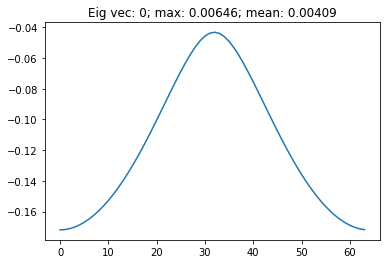

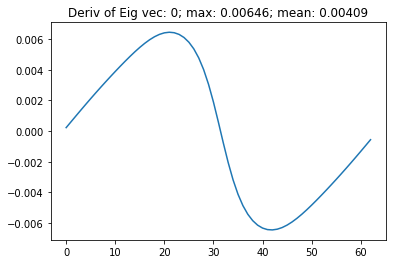

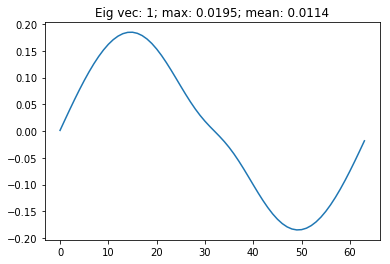

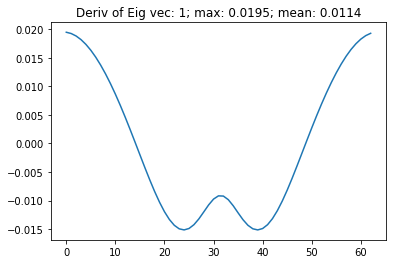

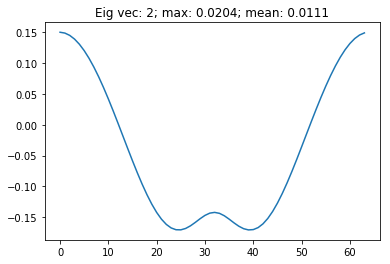

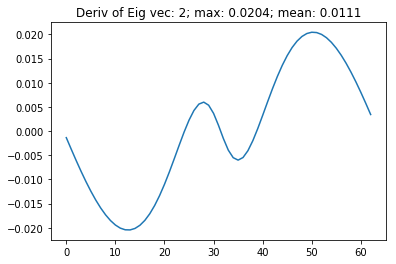

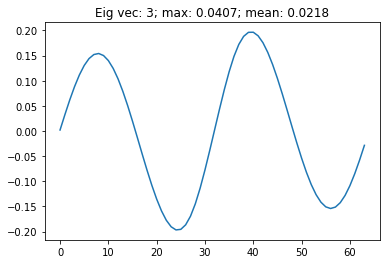

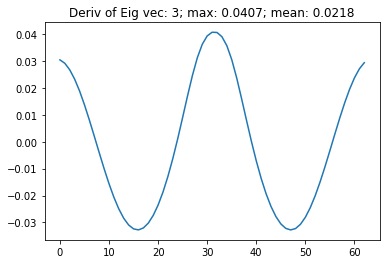

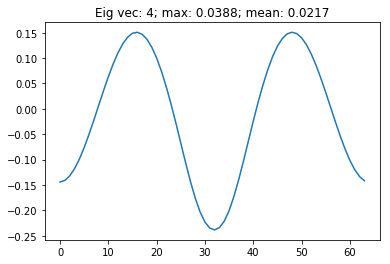

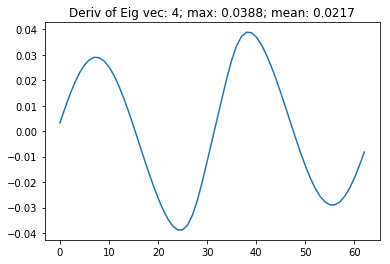

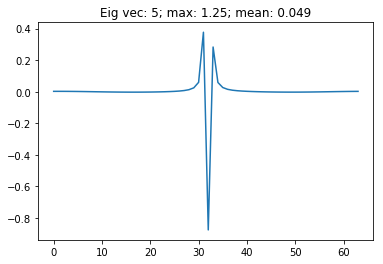

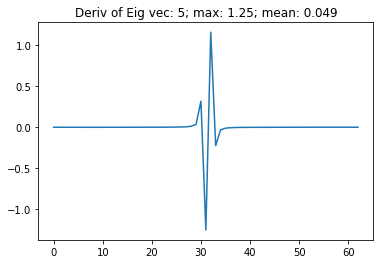

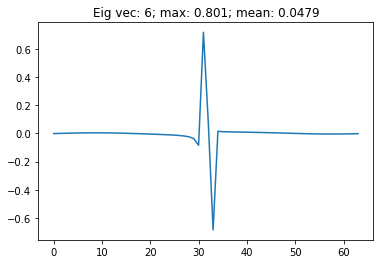

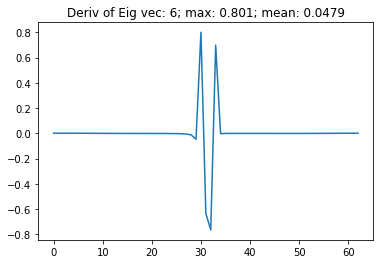

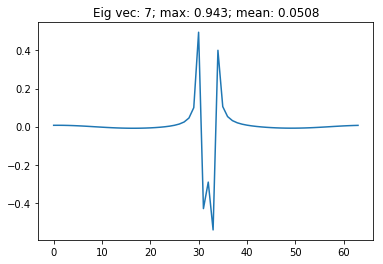

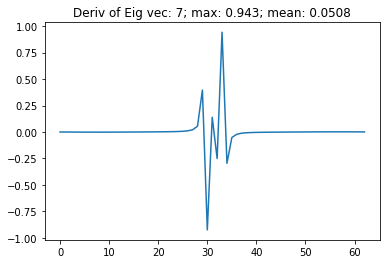

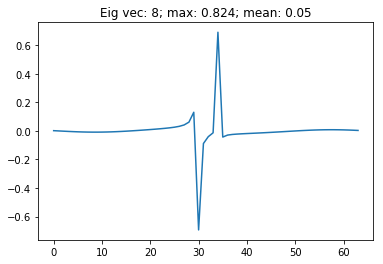

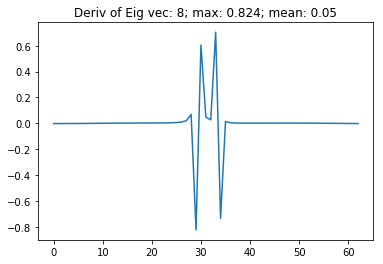

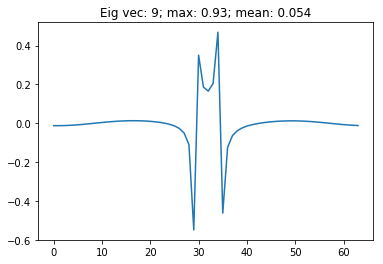

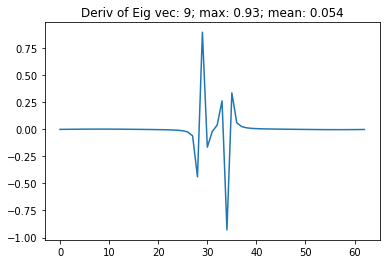

In [7]:
max_deriv = np.max(np.abs(dQxdt), axis=0)
mean_deriv = np.mean(np.abs(dQxdt), axis=0)
max_deriv2 = np.max(np.abs(d2Qxdt2), axis=0)
mean_deriv2 = np.mean(np.abs(d2Qxdt2), axis=0)
maxd_norm = (max_deriv - max_deriv.min())/(max_deriv.max() - max_deriv.min())
meand_norm = (mean_deriv - mean_deriv.min())/(mean_deriv.max() - mean_deriv.min())
maxd2_norm = (max_deriv2 - max_deriv2.min())/(max_deriv2.max() - max_deriv2.min())
meand2_norm = (mean_deriv2 - mean_deriv2.min())/(mean_deriv2.max() - mean_deriv2.min())

plt.figure()
plt.plot(max_deriv)
plt.plot(mean_deriv)
plt.title('Max & Mean absolute deriv of eigen vector')
plt.xlabel('Eigen vector number')
plt.ylabel('derivative')
plt.legend(['Max', 'Mean'])

plt.figure()
plt.plot(max_deriv2)
plt.plot(mean_deriv2)
plt.title('Max & Mean absolute 2nd deriv of eigen vector')
plt.xlabel('Eigen vector number')
plt.ylabel('derivative')
plt.legend(['Max', 'Mean'])

plt.figure()
plt.plot(maxd_norm)
plt.plot(meand_norm)
plt.plot(maxd2_norm)
plt.plot(meand2_norm)
plt.title('Max & Mean absolute 1st & 2nd deriv of eigen vector (rescaled)')
plt.xlabel('Eigen vector number')
plt.ylabel('derivative')
plt.legend(['Max 1st', 'Mean 1st',
            'Max 2nd', 'Mean 2nd'])

for ii in range(10):
    plt.figure()
    plt.plot(Qx[:, ii])
    plt.title(f'Eig vec: {ii}; max: {max_deriv[ii]:0.3}; mean: {mean_deriv[ii]:0.3}')
    
    plt.figure()
    plt.plot(dQxdt[:, ii])
    plt.title(f'Deriv of Eig vec: {ii}; max: {max_deriv[ii]:0.3}; mean: {mean_deriv[ii]:0.3}')

In [8]:
N_lam1 = 7
Q1 = Qx[:, :N_lam1]
Q1 = utilities.upscale_on_loop(Q1.T, coarse)
Q1 = Q1.T
Q1, temp = np.linalg.qr(Q1)
Lam1 = np.diag(Q1.T @ Pz @ Q1)
Pz_ll = Q1 @ np.diag(Lam1) @ Q1.T

In [9]:
Nex = 500
Nez = 40
mu_z = np.random.multivariate_normal(np.zeros(Nz), Pz)
# mu_x = mu_z[::coarse]
# Xens = assimilate.generate_ensemble(Nex, np.zeros(Nx), P_sqrtx)
Xens = assimilate.generate_ensemble(Nex, np.zeros(Nz), P_sqrtz)
Xens = ndimage.uniform_filter1d(Xens, size=coarse)[::coarse]
mu_x = ndimage.uniform_filter1d(mu_z, size=coarse)[::coarse] # note that this window is not centered
Zens = assimilate.generate_ensemble(Nez, np.zeros(Nz), P_sqrtz)

In [10]:
Cxsam = np.corrcoef(Xens)
Lam_xsam, Qxsam = np.linalg.eigh(Cxsam)
Lam_xsam = Lam_xsam[::-1]
Qxsam = Qxsam[:, ::-1]

Czsam = np.corrcoef(Zens)
Lam_zsam, Qzsam = np.linalg.eigh(Czsam)
Lam_zsam = Lam_zsam[::-1]
Qzsam = Qzsam[:, ::-1]

Pxsam = np.cov(Xens)
Pzsam = np.cov(Zens)

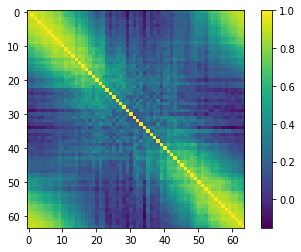

In [11]:
imshow(Qxsam @ np.diag(Lam_xsam) @ Qxsam.T)

In [12]:
dQxdt = np.diff(Qxsam, axis=0)
d2Qxdt2 = np.diff(dQxdt, axis=0)

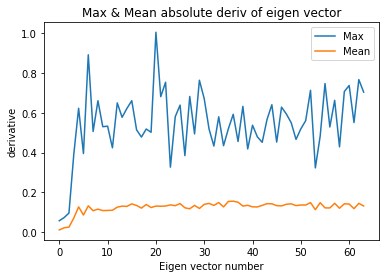

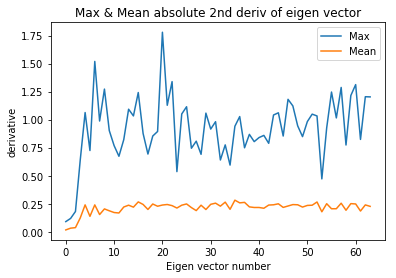

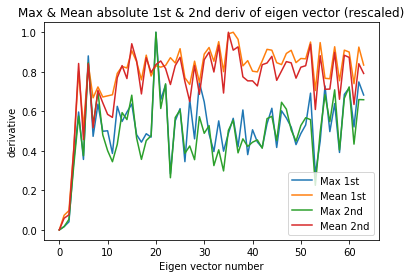

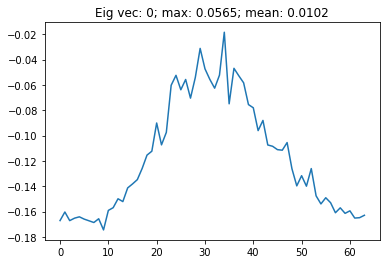

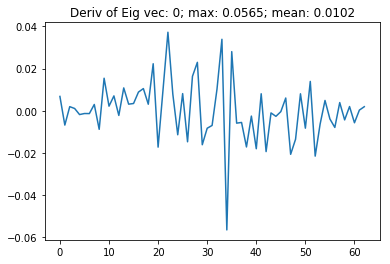

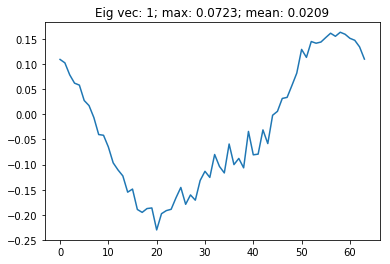

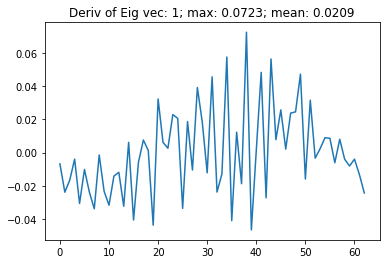

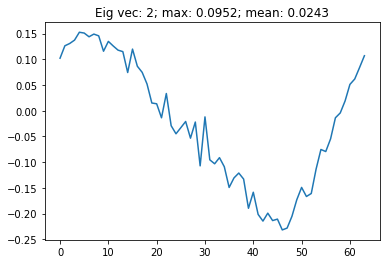

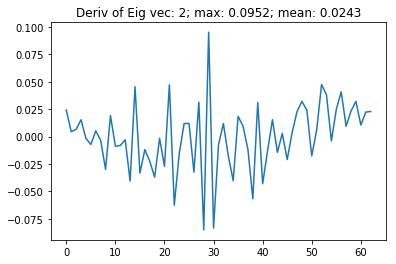

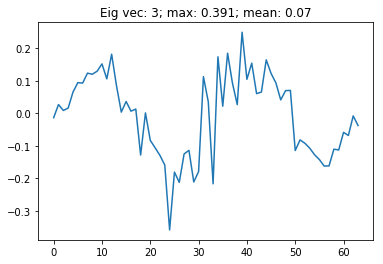

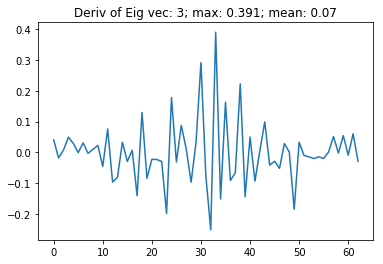

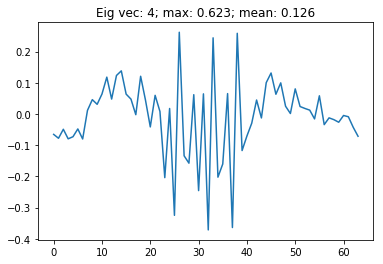

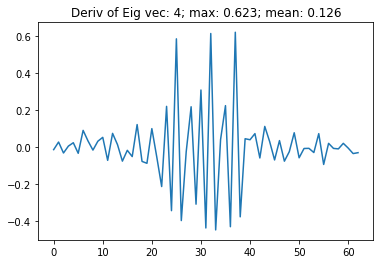

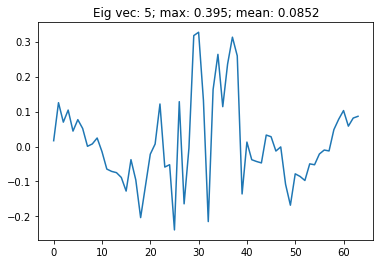

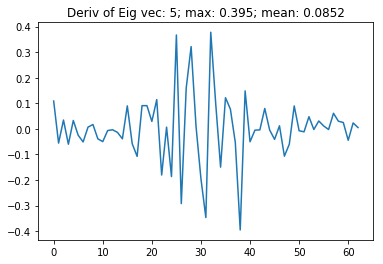

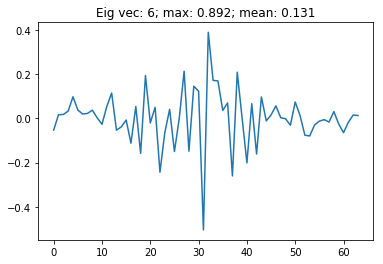

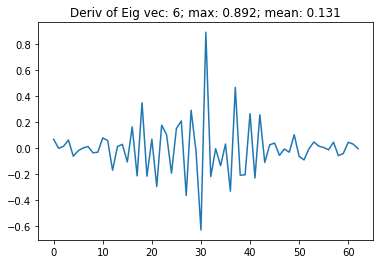

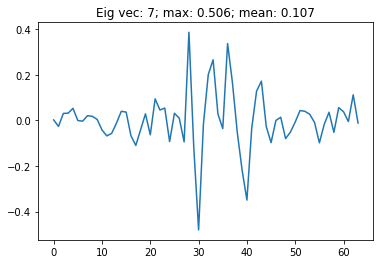

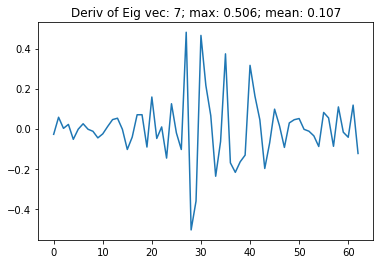

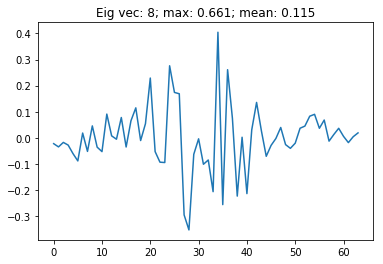

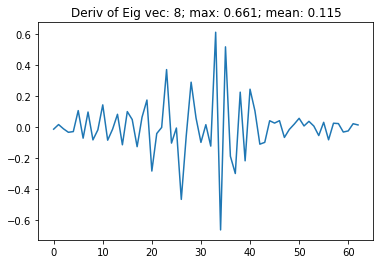

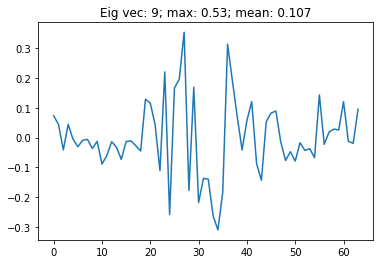

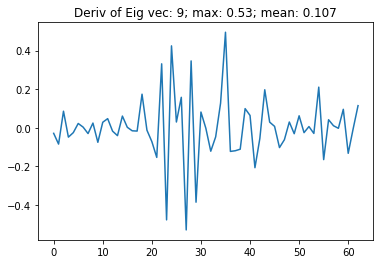

In [13]:
max_deriv = np.max(np.abs(dQxdt), axis=0)
mean_deriv = np.mean(np.abs(dQxdt), axis=0)
max_deriv2 = np.max(np.abs(d2Qxdt2), axis=0)
mean_deriv2 = np.mean(np.abs(d2Qxdt2), axis=0)
maxd_norm = (max_deriv - max_deriv.min())/(max_deriv.max() - max_deriv.min())
meand_norm = (mean_deriv - mean_deriv.min())/(mean_deriv.max() - mean_deriv.min())
maxd2_norm = (max_deriv2 - max_deriv2.min())/(max_deriv2.max() - max_deriv2.min())
meand2_norm = (mean_deriv2 - mean_deriv2.min())/(mean_deriv2.max() - mean_deriv2.min())

plt.figure()
plt.plot(max_deriv)
plt.plot(mean_deriv)
plt.title('Max & Mean absolute deriv of eigen vector')
plt.xlabel('Eigen vector number')
plt.ylabel('derivative')
plt.legend(['Max', 'Mean'])

plt.figure()
plt.plot(max_deriv2)
plt.plot(mean_deriv2)
plt.title('Max & Mean absolute 2nd deriv of eigen vector')
plt.xlabel('Eigen vector number')
plt.ylabel('derivative')
plt.legend(['Max', 'Mean'])

plt.figure()
plt.plot(maxd_norm)
plt.plot(meand_norm)
plt.plot(maxd2_norm)
plt.plot(meand2_norm)
plt.title('Max & Mean absolute 1st & 2nd deriv of eigen vector (rescaled)')
plt.xlabel('Eigen vector number')
plt.ylabel('derivative')
plt.legend(['Max 1st', 'Mean 1st',
            'Max 2nd', 'Mean 2nd'])

for ii in range(10):
    plt.figure()
    plt.plot(Qxsam[:, ii])
    plt.title(f'Eig vec: {ii}; max: {max_deriv[ii]:0.3}; mean: {mean_deriv[ii]:0.3}')
    
    plt.figure()
    plt.plot(dQxdt[:, ii])
    plt.title(f'Deriv of Eig vec: {ii}; max: {max_deriv[ii]:0.3}; mean: {mean_deriv[ii]:0.3}')

In [30]:
N_laml = 4
Qzl = Qxsam[:, :N_laml]
Qzl = utilities.upscale_on_loop(Qzl.T, coarse)
Qzl = Qzl.T
Qzl, temp = np.linalg.qr(Qzl)
Lam_zl = np.diag(Qzl.T @ Czsam @ Qzl)
Cz_ll = Qzl @ np.diag(Lam_zl) @ Qzl.T

Cz_orth = Czsam - Cz_ll

rho0_loc = 0.005
[L_s] = covariance.generate_circulant(
    Nz, dz, rho0_loc,
    covariance.fft_sqd_exp_1d,
    return_eig=False, return_Corr=True)
Cz_ol = L_s * Cz_orth
Cz_loc = Cz_ol + Cz_ll
D_inv_sqrt = np.diag(1/np.sqrt(np.diag(Cz_loc)))
Cz_loc = D_inv_sqrt @ Cz_loc @ D_inv_sqrt

std_zsam = np.std(Zens, axis=1)
Pz_loc = np.diag(std_zsam) @ Cz_loc @ np.diag(std_zsam)

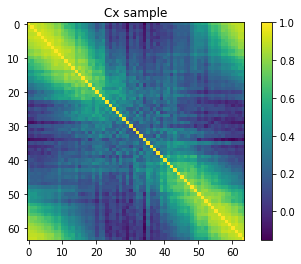

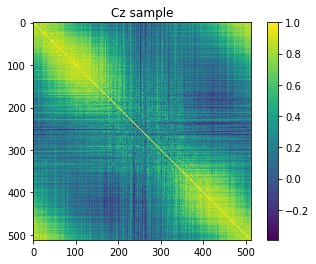

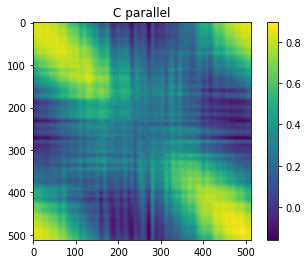

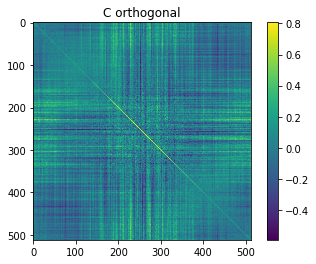

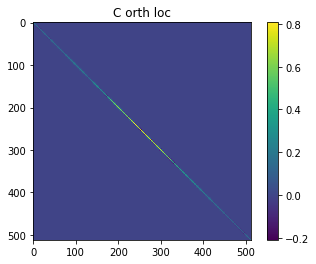

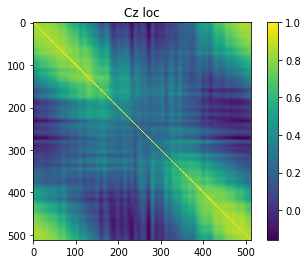

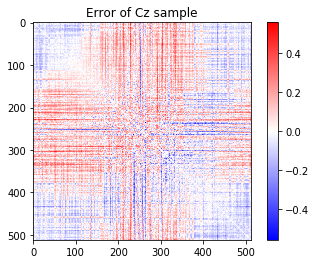

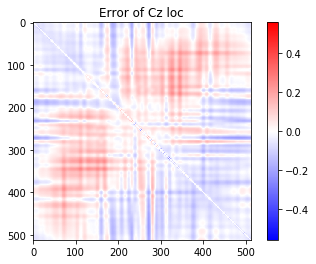

In [31]:
imshow(Cxsam, 'Cx sample')
imshow(Czsam, 'Cz sample')
imshow(Cz_ll, 'C parallel')
imshow(Cz_orth, 'C orthogonal')
imshow(Cz_ol, 'C orth loc')
imshow(Cz_loc, 'Cz loc')



err_Czsam = Czsam - Pz
err_Czloc = Cz_loc - Pz
vmax = np.max([np.abs(err_Czsam).max(),
               np.abs(err_Czloc).max()])

imshow(err_Czsam, 'Error of Cz sample',
       vmin=-vmax, vmax=vmax, cmap='bwr')
imshow(err_Czloc, 'Error of Cz loc',
       vmin=-vmax, vmax=vmax, cmap='bwr')

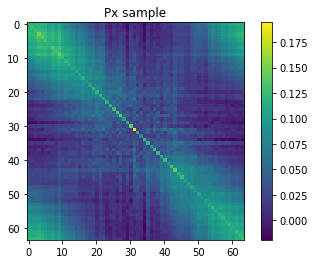

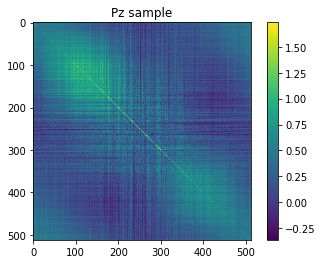

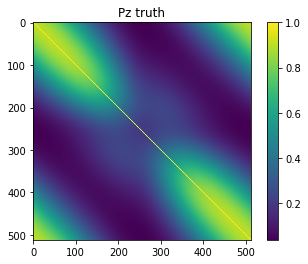

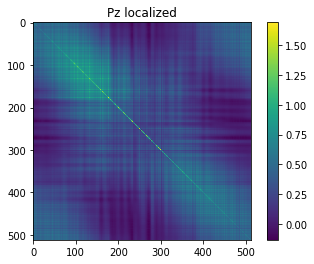

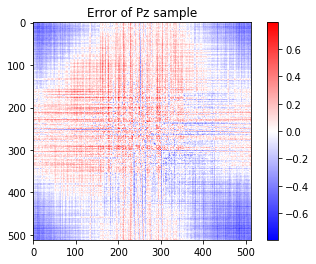

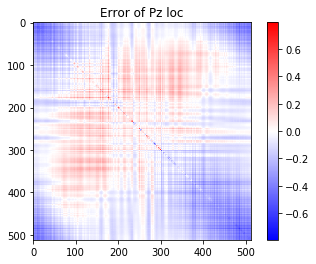

In [32]:
imshow(Pxsam, 'Px sample')
imshow(Pzsam, 'Pz sample')
imshow(Pz, 'Pz truth')
imshow(Pz_loc, 'Pz localized')

err_Pzsam = Pzsam - Pz
err_Pzloc = Pz_loc - Pz
vmax = np.max([np.abs(err_Pzsam).max(),
               np.abs(err_Pzloc).max()])

imshow(err_Pzsam, 'Error of Pz sample',
       vmin=-vmax, vmax=vmax, cmap='bwr')
imshow(err_Pzloc, 'Error of Pz loc',
       vmin=-vmax, vmax=vmax, cmap='bwr')

In [33]:
Xobs = mu_x
Xobs = Xobs[:, None] + np.random.multivariate_normal(np.zeros(Nx), R_var * np.eye(Nx), Nex).T

In [34]:
def assimilate_x(Zens, Zobs, Hz, R, Czsam, std_zsam, rho0_loc_s):
    [L_s] = covariance.generate_circulant(
        Nx, dx, rho0_loc_s,
        covariance.fft_sqd_exp_1d,
        return_eig=False, return_Corr=True)
    Cz_loc = L_s * Czsam
    D_inv_sqrt = np.diag(1/np.sqrt(np.diag(Cz_loc)))
    Cz_loc = D_inv_sqrt @ Cz_loc @ D_inv_sqrt
    Pz_loc = np.diag(std_zsam) @ Cz_loc @ np.diag(std_zsam)
    
    Za = KF(Zens, Zobs, Pz_loc, Hz, R)
    return Za

In [35]:
def KF(Z, Zobs, Pz, H, R):
    K = Pz @ H.T @ np.linalg.pinv(H @ Pz @ H.T + R)
    Za = Z + K @ (Zobs - H @ Z)
    return Za

In [36]:
N_laml = 5
Qzl = Qxsam[:, :N_laml]
Qzl = utilities.upscale_on_loop(Qzl.T, coarse)
Qzl = Qzl.T
Qzl, temp = np.linalg.qr(Qzl)
Lam_zl = np.diag(Qzl.T @ Czsam @ Qzl)
Cz_ll = Qzl @ np.diag(Lam_zl) @ Qzl.T

Cz_orth = Czsam - Cz_ll

rho0_loc = 0.005
[L_s] = covariance.generate_circulant(
    Nz, dz, rho0_loc,
    covariance.fft_sqd_exp_1d,
    return_eig=False, return_Corr=True)
Cz_ol = L_s * Cz_orth
Cz_loc = Cz_ol + Cz_ll
D_inv_sqrt = np.diag(1/np.sqrt(np.diag(Cz_loc)))
Cz_loc = D_inv_sqrt @ Cz_loc @ D_inv_sqrt

std_zsam = np.std(Zens, axis=1)
Pz_loc = np.diag(std_zsam) @ Cz_loc @ np.diag(std_zsam)

In [37]:
def assimilate_eig(Zens, Zobs, Hz, R, Czsam, Cz_ll, std_zsam, rho0_loc_s):
    Cz_orth = Czsam - Cz_ll
    [L_s] = covariance.generate_circulant(
        Nz, dz, rho0_loc_s,
        covariance.fft_sqd_exp_1d,
        return_eig=False, return_Corr=True)
    Cz_ol = L_s * Cz_orth
    Cz_loc = Cz_ol + Cz_ll
    D_inv_sqrt = np.diag(1/np.sqrt(np.diag(Cz_loc)))
    Cz_loc = D_inv_sqrt @ Cz_loc @ D_inv_sqrt
    Pz_loc = np.diag(std_zsam) @ Cz_loc @ np.diag(std_zsam)
    
    Za = KF(Zens, Zobs, Pz_loc, Hz, R)
    return Za

In [38]:
Zobs = Hz @ mu_z
Zobs = Zobs[:, None] + np.random.multivariate_normal(np.zeros(Ny), R, Nez).T

In [39]:
aZa = assimilate_eig(Zens, Zobs, Hz, R, Czsam, Cz_ll, std_zsam, rho0_loc)

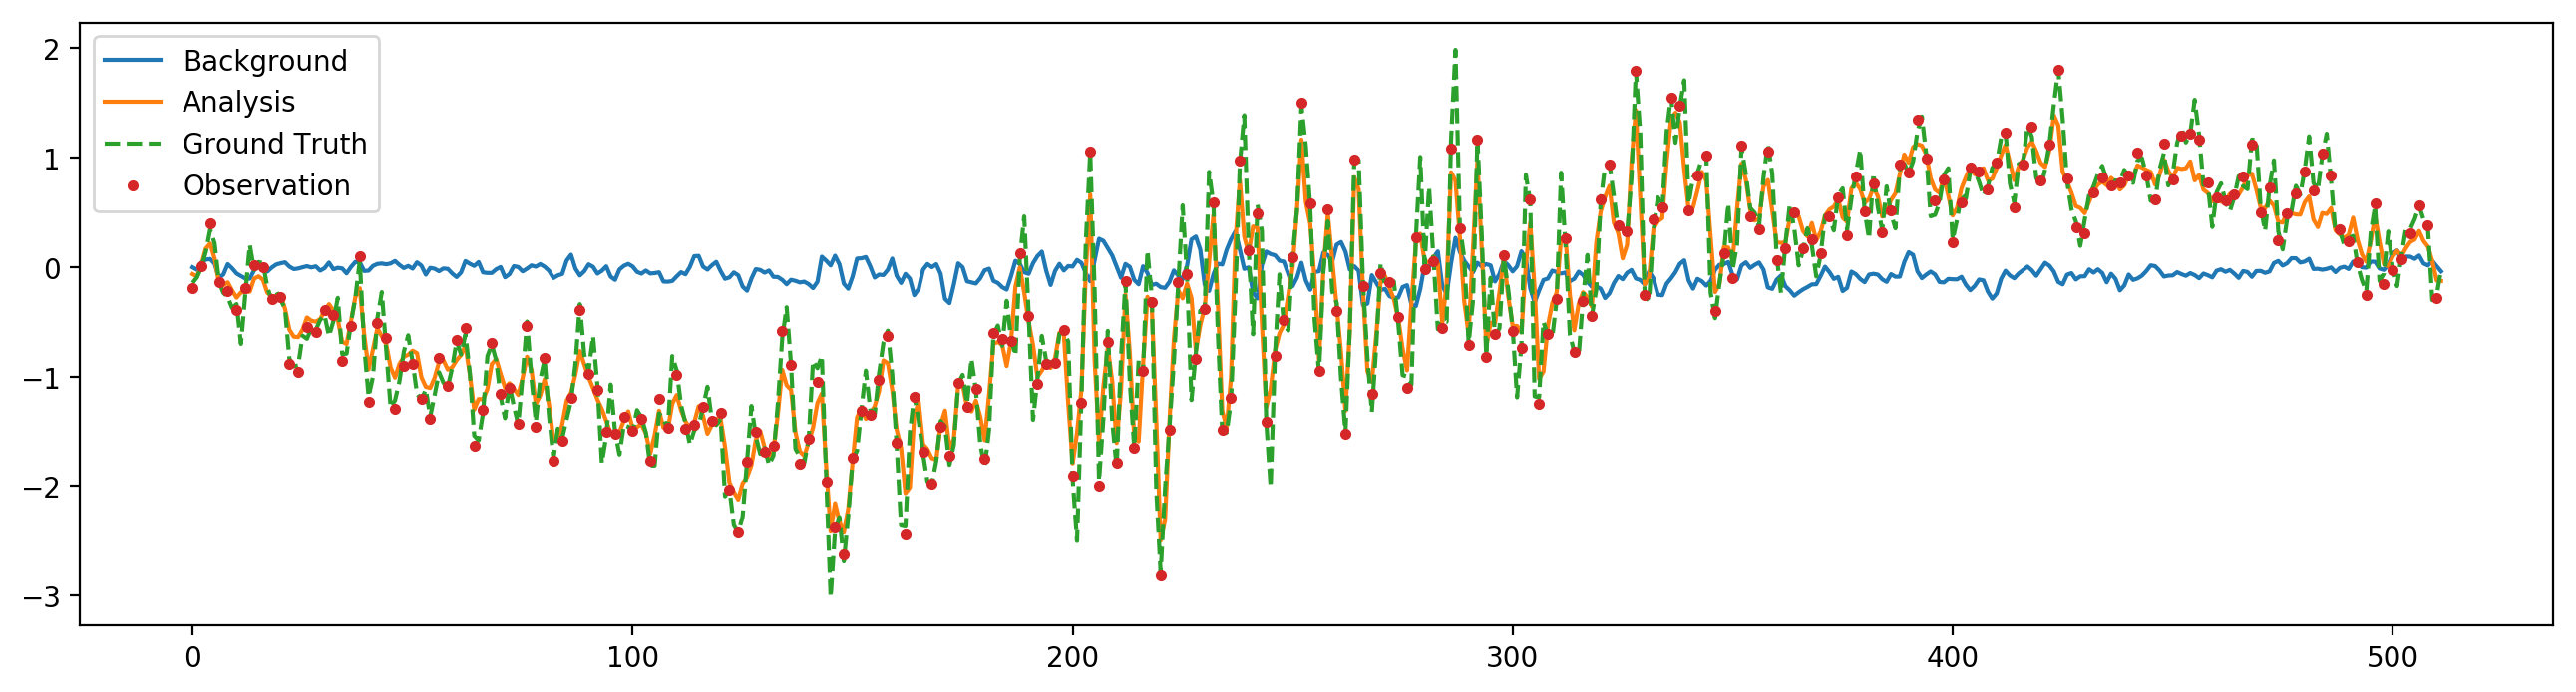

In [40]:
figsize = plt.figaspect(1/4)
plt.figure(figsize=figsize, dpi=200)
plt.plot(z, Zens.mean(axis=1))
plt.plot(z, aZa.mean(axis=1))
plt.plot(z, mu_z, '--')
plt.plot(y, Zobs.mean(axis=1), '.')
plt.legend(['Background', 'Analysis', 'Ground Truth', 'Observation'])

In [41]:
loc_array_eig = np.linspace(0.0001, 0.008, 20)
# loc_array_eig = np.linspace(0.1, 0.001, 50)
rmse_eig = loc_array_eig * np.nan
for count, a_rho0 in enumerate(loc_array_eig):
    aZa = assimilate_eig(Zens, Zobs, Hz, R, Czsam, Cz_ll, std_zsam, a_rho0)
    rmse_eig[count] = np.sqrt(((aZa.mean(axis=1) - mu_z)**2).mean())

In [42]:
def assimilate_stdrd(Zens, Zobs, Hz, R, Czsam, std_zsam, rho0_loc_s):
    [L_s] = covariance.generate_circulant(
        Nz, dz, rho0_loc_s,
        covariance.fft_sqd_exp_1d,
        return_eig=False, return_Corr=True)
    Cz_loc = L_s * Czsam
    D_inv_sqrt = np.diag(1/np.sqrt(np.diag(Cz_loc)))
    Cz_loc = D_inv_sqrt @ Cz_loc @ D_inv_sqrt
    Pz_loc = np.diag(std_zsam) @ Cz_loc @ np.diag(std_zsam)
    
    Za = KF(Zens, Zobs, Pz_loc, Hz, R)
    return Za

In [43]:
# loc_array_stdrd = np.linspace(0.01, 0.001, 20)
loc_array_stdrd = loc_array_eig.copy()
rmse_stdrd = loc_array_stdrd * np.nan
for count, a_rho0 in enumerate(loc_array_eig):
    aZa = assimilate_stdrd(Zens, Zobs, Hz, R, Czsam, std_zsam, a_rho0)
    rmse_stdrd[count] = np.sqrt(((aZa.mean(axis=1) - mu_z)**2).mean())

(0.22575129440170824, 1)

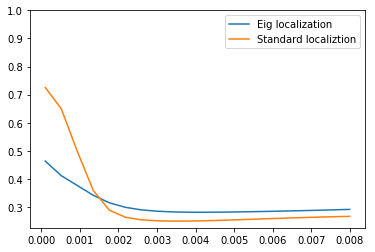

In [44]:
plt.figure()
plt.plot(loc_array_eig, rmse_eig)
plt.plot(loc_array_stdrd, rmse_stdrd)
plt.legend(['Eig localization',
            'Standard localiztion'])
plt.ylim([None, 1])

In [20]:
# std_xsam = np.std(Xens, axis=1)
# loc_array_x = np.linspace(0.2, 0.001, 30)
# # loc_array_eig = np.linspace(0.1, 0.001, 50)
# rmse_x = loc_array_x * np.nan
# for count, a_rho0 in enumerate(loc_array_x):
#     aZa = assimilate_x(Xens, Xobs, np.eye(Nx), R_var * np.eye(Nx), Cxsam, std_xsam, a_rho0)
#     rmse_x[count] = np.sqrt(((aZa.mean(axis=1) - mu_x)**2).mean())

# plt.figure()
# plt.plot(loc_array_x, rmse_x)
# arg = np.argmin(rmse_x)
# print(loc_array_x[arg])
# loc_x = np.round(loc_array_x[arg], 2)
# [L_x] = covariance.generate_circulant(
#         Nx, dx, loc_x,
#         covariance.fft_sqd_exp_1d,
#         return_eig=False, return_Corr=True)
# imshow(L_x)

# Lam_xsam, Qxsam = np.linalg.eigh(L_x * Cxsam)
# Lam_xsam = Lam_xsam[::-1]
# Qxsam = Qxsam[:, ::-1]

# dQxdt = np.diff(Qxsam, axis=0)
# d2Qxdt2 = np.diff(dQxdt, axis=0)

# max_deriv = np.max(np.abs(dQxdt), axis=0)
# mean_deriv = np.mean(np.abs(dQxdt), axis=0)
# max_deriv2 = np.max(np.abs(d2Qxdt2), axis=0)
# mean_deriv2 = np.mean(np.abs(d2Qxdt2), axis=0)
# maxd_norm = (max_deriv - max_deriv.min())/(max_deriv.max() - max_deriv.min())
# meand_norm = (mean_deriv - mean_deriv.min())/(mean_deriv.max() - mean_deriv.min())
# maxd2_norm = (max_deriv2 - max_deriv2.min())/(max_deriv2.max() - max_deriv2.min())
# meand2_norm = (mean_deriv2 - mean_deriv2.min())/(mean_deriv2.max() - mean_deriv2.min())

# plt.figure()
# plt.plot(max_deriv)
# plt.plot(mean_deriv)
# plt.title('Max & Mean absolute deriv of eigen vector')
# plt.xlabel('Eigen vector number')
# plt.ylabel('derivative')
# plt.legend(['Max', 'Mean'])

# plt.figure()
# plt.plot(max_deriv2)
# plt.plot(mean_deriv2)
# plt.title('Max & Mean absolute 2nd deriv of eigen vector')
# plt.xlabel('Eigen vector number')
# plt.ylabel('derivative')
# plt.legend(['Max', 'Mean'])

# plt.figure()
# plt.plot(maxd_norm)
# plt.plot(meand_norm)
# plt.plot(maxd2_norm)
# plt.plot(meand2_norm)
# plt.title('Max & Mean absolute 1st & 2nd deriv of eigen vector (rescaled)')
# plt.xlabel('Eigen vector number')
# plt.ylabel('derivative')
# plt.legend(['Max 1st', 'Mean 1st',
#             'Max 2nd', 'Mean 2nd'])

# for ii in range(10):
#     plt.figure()
#     plt.plot(Qxsam[:, ii])
#     plt.title(f'Eig vec: {ii}; max: {max_deriv[ii]:0.3}; mean: {mean_deriv[ii]:0.3}')
    
#     plt.figure()
#     plt.plot(dQxdt[:, ii])
#     plt.title(f'Deriv of Eig vec: {ii}; max: {max_deriv[ii]:0.3}; mean: {mean_deriv[ii]:0.3}')